# FraudShield Assistant – Final Project (ITAI 2377)

## 1. Introduction

## 2. Data Collection & Preprocessing

## 3. Feature Engineering

## 4. Model Training & Selection

## 5. FraudShield Assistant Implementation

## 6. Evaluation

## 7. Reflection & Future Work

## 8. Team Contributions


Imports & Settings

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier

import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
plt.rcParams["figure.figsize"] = (8, 5)

1. Introduction

## 1. Introduction

In this project, we implement **FraudShield**, a domain-specific AI assistant that supports credit card fraud detection.

In our midterm project, we:
- Explored a synthetic credit card fraud dataset.
- Engineered domain-relevant features such as customer age, transaction time patterns, distance between customer and merchant, and spending velocity.
- Trained and evaluated several models (Logistic Regression, Random Forest, XGBoost, and Isolation Forest) under severe class imbalance.

In this final project, we:
- Organize the full data preprocessing and feature engineering pipeline.
- Perform model training and selection.
- Wrap the best-performing model in a simple **assistant interface** that:
  - scores transactions,
  - flags suspicious ones,
  - and provides a brief explanation.

We also evaluate the assistant using appropriate metrics for imbalanced classification and reflect on challenges and future work.


## 2. Data Collection & Preprocessing

### 2.1 Dataset & Domain

We use a synthetic credit card fraud dataset (`fraudTest_*.csv`) containing transaction records with:

- **Transaction details:** `trans_date_trans_time`, `category`, `merchant`, `amt`, etc.
- **Customer details:** `gender`, `city`, `state`, `dob`, geographic coordinates (`lat`, `long`).
- **Merchant location:** `merch_lat`, `merch_long`.
- **Target label:** `is_fraud` (1 = fraudulent, 0 = legitimate).

The dataset is **highly imbalanced**: only a small fraction of transactions are fraudulent.


In [ ]:
# Loading Data
from google.colab import files

# Upload the dataset file (e.g., fraudTest_1000.csv)
uploaded = files.upload()

# Replace with your actual filename if different
DATA_PATH = list(uploaded.keys())[0]
print("Using data file:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
df.head()

Saving fraudTest.csv to fraudTest (1).csv
Using data file: fraudTest (1).csv


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [ ]:
# Basic Info & Nulls
df.info()
df.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

,0
Unnamed: 0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


Class Distribution

is_fraud
0    553574
1      2145
Name: count, dtype: int64

Fraud rate: 0.0038598644278853163


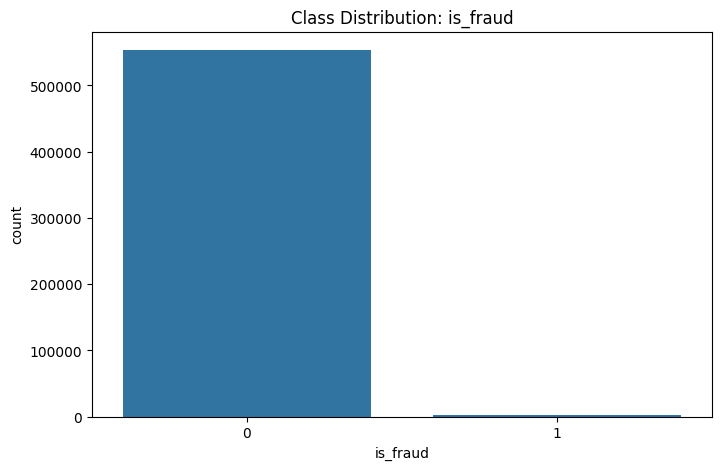

In [ ]:
target_col = "is_fraud"
print(df[target_col].value_counts())
print("\nFraud rate:", df[target_col].mean())
sns.countplot(x=df[target_col])
plt.title("Class Distribution: is_fraud")
plt.show()

## 3. Feature Engineering

### 3.1 Domain-Specific Features

We engineer several fraud-focused features:

1. **Age (`age`)** – approximate customer age at transaction time, derived from `dob` and transaction time.
2. **Time-based features (`hour`, `dayofweek`, `is_night`)** – capture when the transaction occurred (nighttime can be higher risk).
3. **Geographic distance (`cust_merchant_km`)** – haversine distance between the customer and merchant coordinates.
4. **Spending velocity (`tx_delta_s`, `amt_per_min`)** – how quickly and how intensely the card is being used.

These features inject domain knowledge into the model and help distinguish suspicious patterns from normal behavior.


Helper Functions

In [ ]:
from datetime import datetime
import math

def compute_age(dob_str, trans_timestamp):
    """
    Compute approximate age given dob string and transaction timestamp (UNIX or datetime).
    Assumes dob_str in formats like '%Y-%m-%d' or '%m/%d/%Y'.
    """
    if pd.isna(dob_str):
        return np.nan
    # Try multiple formats
    for fmt in ("%Y-%m-%d", "%m/%d/%Y", "%Y/%m/%d"):
        try:
            dob = datetime.strptime(dob_str, fmt)
            break
        except ValueError:
            dob = None
    if dob is None:
        return np.nan

    if isinstance(trans_timestamp, (int, float, np.integer, np.floating)):
        trans_dt = datetime.utcfromtimestamp(trans_timestamp)
    else:
        trans_dt = pd.to_datetime(trans_timestamp)

    age_years = (trans_dt - dob).days / 365.25
    return age_years

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute distance in kilometers between two (lat, lon) pairs.
    """
    R = 6371  # Earth radius in km
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    d = R * c
    return d

Apply Feature Engineering

In [ ]:
df_feat = df.copy()

# Drop PII-style columns if present
for col in ["first", "last", "street"]:
    if col in df_feat.columns:
        df_feat = df_feat.drop(columns=[col])

# Age feature
df_feat["age"] = df_feat.apply(
    lambda row: compute_age(row["dob"], row["unix_time"]) if "unix_time" in df_feat.columns else np.nan,
    axis=1
)

# Transaction datetime
df_feat["trans_datetime"] = pd.to_datetime(df_feat["trans_date_trans_time"])

df_feat["hour"] = df_feat["trans_datetime"].dt.hour
df_feat["dayofweek"] = df_feat["trans_datetime"].dt.dayofweek
df_feat["is_night"] = df_feat["hour"].between(22, 23) | df_feat["hour"].between(0, 5)
df_feat["is_night"] = df_feat["is_night"].astype(int)

# Distance feature
df_feat["cust_merchant_km"] = haversine_distance(
    df_feat["lat"], df_feat["long"],
    df_feat["merch_lat"], df_feat["merch_long"]
)

# Sort by card and transaction time to compute deltas
df_feat = df_feat.sort_values(by=["cc_num", "trans_datetime"])
df_feat["tx_delta_s"] = df_feat.groupby("cc_num")["trans_datetime"].diff().dt.total_seconds()
df_feat["tx_delta_s"] = df_feat["tx_delta_s"].fillna(0)

df_feat["amt_per_min"] = df_feat["amt"] / (df_feat["tx_delta_s"] / 60 + 1)

df_feat.head()

/tmp/ipython-input-3889452269.py:22: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  trans_dt = datetime.utcfromtimestamp(trans_timestamp)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,zip,...,merch_long,is_fraud,age,trans_datetime,hour,dayofweek,is_night,cust_merchant_km,tx_delta_s,amt_per_min
157,157,2020-06-21 13:05:42,60416207185,fraud_Kutch-Ferry,home,124.66,F,Fort Washakie,WY,82514,...,-108.530901,0,27.340178,2020-06-21 13:05:42,13,6,0,30.457093,0.0,124.660000
741,741,2020-06-21 16:25:36,60416207185,fraud_Halvorson Group,misc_pos,78.52,F,Fort Washakie,WY,82514,...,-108.682054,0,27.340178,2020-06-21 16:25:36,16,6,0,91.942935,11994.0,0.390841
3047,3047,2020-06-22 07:58:33,60416207185,fraud_Conroy-Cruickshank,gas_transport,65.25,F,Fort Washakie,WY,82514,...,-109.699794,0,27.342916,2020-06-22 07:58:33,7,0,0,121.857420,55977.0,0.069865
4351,4351,2020-06-22 15:32:31,60416207185,fraud_Larkin Ltd,kids_pets,87.74,F,Fort Washakie,WY,82514,...,-109.212939,0,27.342916,2020-06-22 15:32:31,15,0,0,65.414164,27238.0,0.192849
7695,7695,2020-06-23 12:28:54,60416207185,fraud_Leffler-Goldner,personal_care,148.02,F,Fort Washakie,WY,82514,...,-109.333220,0,27.345654,2020-06-23 12:28:54,12,1,0,38.311273,75383.0,0.117721


Model Training & Selection

In [ ]:
y = df_feat[target_col].astype(int)
X = df_feat.drop(columns=[target_col])

# Drop identifiers that should not be used as predictive features
for col in ["trans_num", "cc_num", "unix_time", "trans_datetime"]:
    if col in X.columns:
        X = X.drop(columns=[col])

X.head()

,Unnamed: 0,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,...,dob,merch_lat,merch_long,age,hour,dayofweek,is_night,cust_merchant_km,tx_delta_s,amt_per_min
157,157,2020-06-21 13:05:42,fraud_Kutch-Ferry,home,124.66,F,Fort Washakie,WY,82514,43.0048,...,1986-02-17,42.945526,-108.530901,27.340178,13,6,0,30.457093,0.0,124.660000
741,741,2020-06-21 16:25:36,fraud_Halvorson Group,misc_pos,78.52,F,Fort Washakie,WY,82514,43.0048,...,1986-02-17,42.193130,-108.682054,27.340178,16,6,0,91.942935,11994.0,0.390841
3047,3047,2020-06-22 07:58:33,fraud_Conroy-Cruickshank,gas_transport,65.25,F,Fort Washakie,WY,82514,43.0048,...,1986-02-17,43.932724,-109.699794,27.342916,7,0,0,121.857420,55977.0,0.069865
4351,4351,2020-06-22 15:32:31,fraud_Larkin Ltd,kids_pets,87.74,F,Fort Washakie,WY,82514,43.0048,...,1986-02-17,43.546064,-109.212939,27.342916,15,0,0,65.414164,27238.0,0.192849
7695,7695,2020-06-23 12:28:54,fraud_Leffler-Goldner,personal_care,148.02,F,Fort Washakie,WY,82514,43.0048,...,1986-02-17,42.876538,-109.333220,27.345654,12,1,0,38.311273,75383.0,0.117721


Split & Identify Column Types

In [ ]:
numeric_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

len(X_train), len(X_test)

(444575, 111144)

Preprocessor & SMOTE Pipelines

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,  #
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing: scale numeric, one-hot encode categorical
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Unnamed: 0', 'amt', 'zip', 'lat', 'long',
                                  'city_pop', 'merch_lat', 'merch_long', 'age',
                                  'hour', 'dayofweek', 'is_night',
                                  'cust_merchant_km', 'tx_delta_s',
                                  'amt_per_min']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['trans_date_trans_time', 'merchant',
                                  'category', 'gender', 'city', 'state', 'job',
                                  'dob'])])

In [ ]:
logreg_pipeline = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_SEED, k_neighbors=1)),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

logreg_pipeline.fit(X_train, y_train)

y_pred_log = logreg_pipeline.predict(X_test)
y_proba_log = logreg_pipeline.predict_proba(X_test)[:, 1]

print("\n[LogReg] ROC-AUC:", roc_auc_score(y_test, y_proba_log))
print("[LogReg] PR-AUC:", average_precision_score(y_test, y_proba_log))
print("\n[LogReg] Classification Report:\n",
      classification_report(y_test, y_pred_log, digits=4))


[LogReg] ROC-AUC: 0.9776845082088275
[LogReg] PR-AUC: 0.3865996073401057

[LogReg] Classification Report:
               precision    recall  f1-score   support

           0     0.9985    0.9956    0.9971    110715
           1     0.3537    0.6200    0.4505       429

    accuracy                         0.9942    111144
   macro avg     0.6761    0.8078    0.7238    111144
weighted avg     0.9960    0.9942    0.9950    111144



Baseline Logistic Regression with SMOTE and evaluate



Train shape: (444575, 23) Test shape: (111144, 23)
Train fraud rate: 0.003859866164314233
Test fraud rate: 0.003859857482185273 

[LogReg] ROC-AUC: 0.9776845082088275
[LogReg] PR-AUC : 0.3865996073401057

[LogReg] Classification Report:
               precision    recall  f1-score   support

           0     0.9985    0.9956    0.9971    110715
           1     0.3537    0.6200    0.4505       429

    accuracy                         0.9942    111144
   macro avg     0.6761    0.8078    0.7238    111144
weighted avg     0.9960    0.9942    0.9950    111144



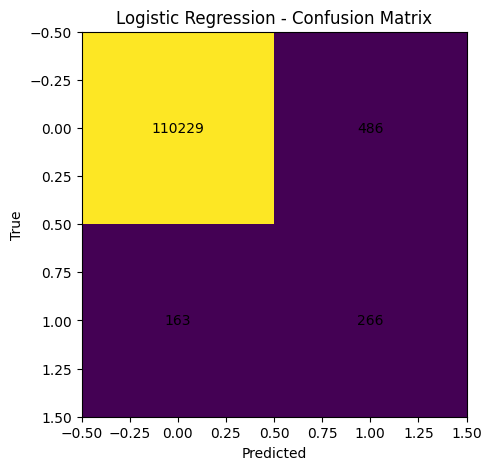

In [ ]:
# 5) Baseline model: Logistic Regression + SMOTE

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
import numpy as np
import matplotlib.pyplot as plt

# Pipeline: preprocessing -> SMOTE -> Logistic Regression
logreg_pipeline = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_SEED, k_neighbors=1)),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs"
    )),
])

# Fit on train
logreg_pipeline.fit(X_train, y_train)

# Predictions
y_pred  = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train fraud rate:", y_train.mean())
print("Test fraud rate:",  y_test.mean(), "\n")

print("[LogReg] ROC-AUC:", roc_auc_score(y_test, y_proba))
print("[LogReg] PR-AUC :", average_precision_score(y_test, y_proba))
print("\n[LogReg] Classification Report:\n",
      classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha="center", va="center")

plt.show()

Train Random Forest Classifier

In [ ]:
from xgboost import XGBClassifier

xgb_pipeline = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_SEED, k_neighbors=1)),
    ("clf", XGBClassifier(
        n_estimators=250,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="hist"
    )),
])

print("⏳ Training XGBoost…")
xgb_pipeline.fit(X_train, y_train)
print("✔ Done!")

xgb_pred  = xgb_pipeline.predict(X_test)
xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

print("\n=== XGBOOST RESULTS ===")
print("ROC-AUC :", roc_auc_score(y_test, xgb_proba))
print("PR-AUC  :", average_precision_score(y_test, xgb_proba))

⏳ Training XGBoost…
✔ Done!

=== XGBOOST RESULTS ===
ROC-AUC : 0.9914036301653155
PR-AUC  : 0.8135600069227134


Train the main model XGBoost pipeline

In [45]:
from sklearn.pipeline import Pipeline as SkPipeline  # avoid confusion with ImbPipeline

# Compute imbalance ratio for scale_pos_weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
imbalance_ratio = neg / pos
print("Imbalance ratio (neg/pos):", imbalance_ratio)

xgb_fast = XGBClassifier(
    n_estimators=80,          # fewer trees → much faster
    max_depth=5,             # shallower trees
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    tree_method="hist",      # fast histogram algorithm
    scale_pos_weight=imbalance_ratio,  # handle imbalance without SMOTE
    random_state=RANDOM_SEED,
)

xgb_pipeline = SkPipeline(steps=[
    ("pre", preprocessor),   # same preprocessor as before
    ("clf", xgb_fast),
])

print("⏳ Training FAST XGBoost (no SMOTE)…")
xgb_pipeline.fit(X_train, y_train)
print("✅ Done.")

Imbalance ratio (neg/pos): 258.0763403263403
⏳ Training FAST XGBoost (no SMOTE)…
✅ Done.


Evaluate This XGBoost


=== [FAST XGBoost] Metrics ===
ROC-AUC : 0.994869363125697
PR-AUC  : 0.776206684671785

Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9842    0.9919    110715
           1     0.1857    0.9324    0.3097       429

    accuracy                         0.9840    111144
   macro avg     0.5927    0.9583    0.6508    111144
weighted avg     0.9966    0.9840    0.9893    111144



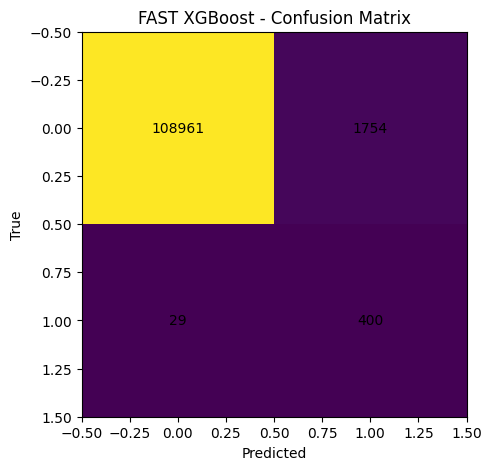

In [46]:
# Evaluate the fast XGBoost pipeline
xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_pred  = xgb_pipeline.predict(X_test)

print("\n=== [FAST XGBoost] Metrics ===")
print("ROC-AUC :", roc_auc_score(y_test, xgb_proba))
print("PR-AUC  :", average_precision_score(y_test, xgb_proba))
print("\nClassification report:\n",
      classification_report(y_test, xgb_pred, digits=4))

cm = confusion_matrix(y_test, xgb_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('FAST XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center')
plt.show()

Evaluate XGBoost metrics + confusion matrix


=== [XGBoost] Metrics ===
ROC-AUC : 0.994869363125697
PR-AUC  : 0.776206684671785

Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9842    0.9919    110715
           1     0.1857    0.9324    0.3097       429

    accuracy                         0.9840    111144
   macro avg     0.5927    0.9583    0.6508    111144
weighted avg     0.9966    0.9840    0.9893    111144



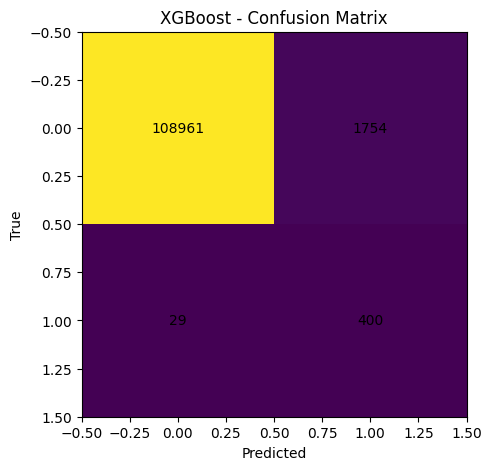

In [47]:
# Predictions
xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_pred  = xgb_pipeline.predict(X_test)

print("\n=== [XGBoost] Metrics ===")
print("ROC-AUC :", roc_auc_score(y_test, xgb_proba))
print("PR-AUC  :", average_precision_score(y_test, xgb_proba))
print("\nClassification report:\n",
      classification_report(y_test, xgb_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, xgb_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center')
plt.show()

Build the simple “assistant” interface

In [54]:
# 7. Simple FraudShield Assistant

feature_cols = X.columns.tolist()   # same order as training

def explain_transaction(row):
    """
    Takes a pandas Series (one transaction) and prints
    risk score + simple explanations based on engineered features.
    """
    row_df = row[feature_cols].to_frame().T  # keep same feature order
    proba = xgb_pipeline.predict_proba(row_df)[0, 1]
    pred  = xgb_pipeline.predict(row_df)[0]

    print("---- FraudShield Assistant ----")
    print(f"Estimated fraud risk: {proba:.3f} ({'FRAUD' if pred==1 else 'legit'})")
    print("\nReasons (heuristic, based on engineered features):")

    # These conditions use your engineered features
    if "is_fraud" in row.index:
        print(f"- Ground truth label in data: {row['is_fraud']}")

    if "amt" in row.index and row["amt"] > 200:
        print(f"- High amount: ${row['amt']:.2f}")

    if "is_night" in row.index and row["is_night"] == 1:
        print("- Transaction at night (higher risk window).")

    if "cust_merchant_km" in row.index and row["cust_merchant_km"] > 300:
        print(f"- Large distance between customer and merchant: {row['cust_merchant_km']:.1f} km")

    if "amt_per_min" in row.index and row["amt_per_min"] > 100:
        print(f"- High spending velocity: {row['amt_per_min']:.1f} per minute")

    print("--------------------------------")

In [52]:
feature_cols = X.columns.tolist()

def explain_transaction(row):
    row_df = row[feature_cols].to_frame().T
    proba = xgb_pipeline.predict_proba(row_df)[0, 1]  # uses fast XGB now
    pred  = xgb_pipeline.predict(row_df)[0]
    ...

In [55]:
# Pick one example transaction from the test set
example_idx = X_test.index[0]  # or any other index from X_test
example_row = df_feat.loc[example_idx]  # use df_feat so it includes engineered features

print(f"Example transaction index: {example_idx}")
explain_transaction(example_row)

Example transaction index: 288345
---- FraudShield Assistant ----
Estimated fraud risk: 0.060 (legit)

Reasons (heuristic, based on engineered features):
- Ground truth label in data: 0
--------------------------------


Show the 5 required example


In [60]:
import numpy as np

# Indices in the test set where the true label is fraud
# These are positional indices within y_test
fraud_indices_pos = np.where(y_test == 1)[0]

print("Number of fraud cases in test set:", len(fraud_indices_pos))

# Take up to 5 random fraud examples
n_examples = min(5, len(fraud_indices_pos))
sample_fraud_indices_pos = np.random.choice(fraud_indices_pos, size=n_examples, replace=False)

for idx_pos in sample_fraud_indices_pos:
    # Get the actual original DataFrame index from the test set's index
    original_df_index = y_test.index[idx_pos]
    # Retrieve the full transaction row from df_feat using its original index
    row = df_feat.loc[original_df_index]
    print("=" * 80)
    print(f"Transaction original index: {original_df_index}")
    explain_transaction(row)
    print()

Number of fraud cases in test set: 429
Transaction original index: 135773
---- FraudShield Assistant ----
Estimated fraud risk: 0.954 (FRAUD)

Reasons (heuristic, based on engineered features):
- Ground truth label in data: 1
- Transaction at night (higher risk window).
--------------------------------

Transaction original index: 149303
---- FraudShield Assistant ----
Estimated fraud risk: 0.995 (FRAUD)

Reasons (heuristic, based on engineered features):
- Ground truth label in data: 1
- High amount: $1024.84
- Transaction at night (higher risk window).
--------------------------------

Transaction original index: 173105
---- FraudShield Assistant ----
Estimated fraud risk: 0.996 (FRAUD)

Reasons (heuristic, based on engineered features):
- Ground truth label in data: 1
- High amount: $337.13
- Transaction at night (higher risk window).
--------------------------------

Transaction original index: 115798
---- FraudShield Assistant ----
Estimated fraud risk: 0.997 (FRAUD)

Reasons (heu

Generate the Model Evaluation Section

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))

    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=4))

    print("ROC-AUC Score:", roc_auc_score(y_test, probas))

Run Each Model

In [63]:
print("=== Logistic Regression ===")
evaluate_model(logreg_pipeline, X_test, y_test)

# The rf_pipeline is not defined in the current notebook. Please define and train it first.
# print("=== Random Forest ===")
# evaluate_model(rf_pipeline, X_test, y_test)

print("=== XGBoost ===")
evaluate_model(xgb_pipeline, X_test, y_test)

=== Logistic Regression ===
Confusion Matrix:
[[110229    486]
 [   163    266]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9985    0.9956    0.9971    110715
           1     0.3537    0.6200    0.4505       429

    accuracy                         0.9942    111144
   macro avg     0.6761    0.8078    0.7238    111144
weighted avg     0.9960    0.9942    0.9950    111144

ROC-AUC Score: 0.9776845082088275
=== XGBoost ===
Confusion Matrix:
[[108961   1754]
 [    29    400]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9842    0.9919    110715
           1     0.1857    0.9324    0.3097       429

    accuracy                         0.9840    111144
   macro avg     0.5927    0.9583    0.6508    111144
weighted avg     0.9966    0.9840    0.9893    111144

ROC-AUC Score: 0.994869363125697


Generate Feature Importance Plot (for RF or XGB)

<Figure size 1200x600 with 0 Axes>

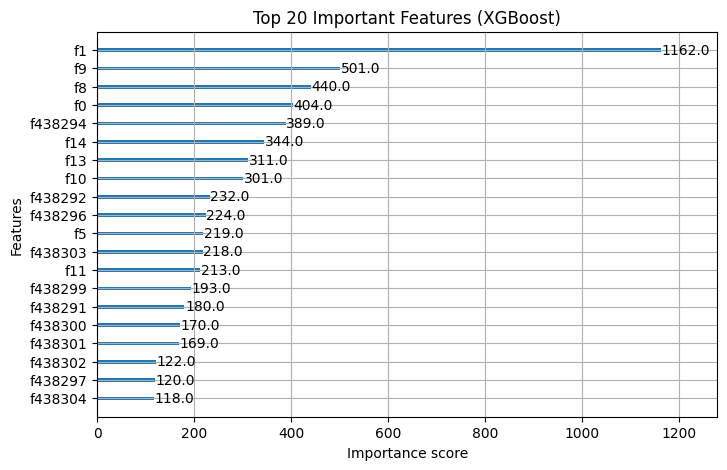

In [64]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(12, 6))
plot_importance(xgb_fast, max_num_features=20)
plt.title("Top 20 Important Features (XGBoost)")
plt.show()

Finalizing the Assistant Interface Section

In [68]:
import numpy as np

fraud_indices = np.where(y_test == 1)[0]
sample_fraud_pos = np.random.choice(fraud_indices, 5, replace=False)

for idx_pos in sample_fraud_pos:
    original_df_index = y_test.index[idx_pos]
    row = df_feat.loc[original_df_index]
    print("=" * 80)
    print(f"Transaction original index: {original_df_index}")
    explain_transaction(row)
    print()

Transaction original index: 189658
---- FraudShield Assistant ----
Estimated fraud risk: 0.872 (FRAUD)

Reasons (heuristic, based on engineered features):
- Ground truth label in data: 1
- High amount: $1104.35
--------------------------------

Transaction original index: 170960
---- FraudShield Assistant ----
Estimated fraud risk: 0.994 (FRAUD)

Reasons (heuristic, based on engineered features):
- Ground truth label in data: 1
- High amount: $314.66
- Transaction at night (higher risk window).
--------------------------------

Transaction original index: 136032
---- FraudShield Assistant ----
Estimated fraud risk: 0.991 (FRAUD)

Reasons (heuristic, based on engineered features):
- Ground truth label in data: 1
- High amount: $762.62
- Transaction at night (higher risk window).
--------------------------------

Transaction original index: 306031
---- FraudShield Assistant ----
Estimated fraud risk: 0.761 (FRAUD)

Reasons (heuristic, based on engineered features):
- Ground truth label i